In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Data preparation

In [0]:
recipes = spark.read.option("sep", ",").option("quote", "\"").option("escape", "\"").option("header", "true").option("multiline", "true").csv("dbfs:/FileStore/shared_uploads/yue.zhang@sjsu.edu/recipes.csv")
reviews = spark.read.option("sep", ",").option("quote", "\"").option("escape", "\"").option("header", "true").option("multiline", "true").csv("dbfs:/FileStore/shared_uploads/yue.zhang@sjsu.edu/reviews.csv")

In [0]:
recipes.createOrReplaceTempView("recipes")
reviews.createOrReplaceTempView("reviews")

In [0]:
%sql
select *
from recipes
limit 100

RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen Dessert recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/YUeirxMLQaeE1h3v3qnM_229%20berry%20blue%20frzn%20dess.jpg"", ""https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/AFPDDHATWzQ0b1CDpDAT_255%20berry%20blue%20frzn%20dess.jpg"", ""https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/UYgf9nwMT2SGGJCuzILO_228%20berry%20blue%20frzn%20dess.jpg"", ""https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/PeBMJN2TGSaYks2759BA_20140722_202142.jpg"", ""https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/picuaETeN.jpg"", ""https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/pictzvxW5.jpg"")",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"", ""Healthy"", ""Free Of..."", ""Summer"", ""Weeknight"", ""Freezer"", ""Easy"")","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla yogurt"", ""lemon juice"")",4.5,4,170.9,2.5,1.3,8,29.8,37.1,3.6,30.2,3.2,4,NA,"c(""Toss 2 cups berries with sugar."", ""Let stand for 45 minutes, stirring occasionally."", ""Transfer berry-sugar mixture to food processor."", ""Add yogurt and process until smooth."", ""Strain through fine sieve. Pour into baking pan (or transfer to ice cream maker and process according to manufacturers' directions). Freeze uncovered until edges are solid but centre is soft. Transfer to processor and blend until smooth again."", ""Return to pan and freeze until edges are solid."", ""Transfer to processor and blend until smooth again."", ""Fold in remaining 2 cups of blueberries."", ""Pour into plastic mold and freeze overnight. Let soften slightly to serve."")"
39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/39/picM9Mhnw.jpg"", ""https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/39/picHv4Ocr.jpg"")",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"", ""Meat"", ""Asian"", ""Indian"", ""Weeknight"", ""Stove Top"")","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ""1"", ""1"", ""1/4"", ""1/4"", ""1/2"", ""1/4"", ""2"", ""3"", NA, ""2"", ""1"", ""1"", ""8"", ""2"", ""1/3"", ""1/3"", ""1/3"", ""6"")","c(""saffron"", ""milk"", ""hot green chili peppers"", ""onions"", ""garlic"", ""clove"", ""peppercorns"", ""cardamom seed"", ""cumin seed"", ""poppy seed"", ""mace"", ""cilantro"", ""mint leaf"", ""fresh lemon juice"", ""plain yogurt"", ""boneless chicken"", ""salt"", ""ghee"", ""onion"", ""tomatoes"", ""basmati rice"", ""long-grain rice"", ""raisins"", ""cashews"", ""eggs"")",3,1,1110.7,58.8,16.6,372.8,368.4,84.4,9,20.4,63.4,6,NA,"c(""Soak saffron in warm milk for 5 minutes and puree in blender."", ""Add chiles, onions, ginger, garlic, cloves, peppercorns, cardamom seeds, cinnamon, coriander and cumin seeds, poppy seeds, nutmeg, mace, cilantro or mint leaves and lemon juice. Blend into smooth paste. Put paste into large bowl, add yogurt and mix well."", ""Marinate chicken in yogurt mixture with salt, covered for at least 2 - 6 hours in refrigerator."", ""In skillet. heat oil over medium heat for 1 minute. Ad

In [0]:
recipes_clean = spark.sql("""
select RecipeId, Description, RecipeInstructions, ReviewCount, CookTime, PrepTime, RecipeCategory, RecipeIngredientParts, AggregatedRating, Calories, FatContent, SaturatedFatContent, CholesterolContent, SodiumContent, CarbohydrateContent, FiberContent, SugarContent, ProteinContent, RecipeServings 
from recipes
where AggregatedRating != 'NA' and ReviewCount > 1
""")

In [0]:
recipes_clean.createOrReplaceTempView("recipes_clean")

# Feature processing

In [0]:
### Feature: CookDuration, PrepDuration
recipes_clean = recipes_clean.withColumn('CookHours', F.regexp_extract(F.col('CookTime'), '(\d+)(?=H)', 0).cast('int'))
recipes_clean = recipes_clean.withColumn('CookMinutes', F.regexp_extract(F.col('CookTime'), '(\d+)(?=M)', 0).cast('int'))
recipes_clean = recipes_clean.fillna({'CookHours': 0, 'CookMinutes': 0})
recipes_clean = recipes_clean.withColumn('CookDuration', recipes_clean['CookHours'] * 60 + recipes_clean['CookMinutes'])

recipes_clean = recipes_clean.withColumn('PrepHours', F.regexp_extract(F.col('PrepTime'), '(\d+)(?=H)', 0).cast('int'))
recipes_clean = recipes_clean.withColumn('PrepMinutes', F.regexp_extract(F.col('PrepTime'), '(\d+)(?=M)', 0).cast('int'))
recipes_clean = recipes_clean.fillna({'PrepHours': 0, 'PrepMinutes': 0})
recipes_clean = recipes_clean.withColumn('PrepDuration', recipes_clean['PrepHours'] * 60 + recipes_clean['PrepMinutes'])

recipes_clean = recipes_clean.drop(*['CookTime', 'CookHours', 'CookMinutes', 'PrepTime', 'PrepHours', 'PrepMinutes'])

### Feature: DescriptionLen
recipes_clean = recipes_clean.withColumn('DescriptionLen', F.length(recipes_clean['Description']))
recipes_clean = recipes_clean.drop('Description')

### Feature: RecipeIngredientPartsCount
recipes_clean = recipes_clean.withColumn('RecipeIngredientPartsCount', F.size(F.split(F.col('RecipeIngredientParts'), ',')))
recipes_clean = recipes_clean.drop('RecipeIngredientParts')

### Feature: RecipeInstructionSteps
recipes_clean = recipes_clean.withColumn('RecipeInstructionSteps', F.size(F.split(F.col('RecipeInstructions'), ',')))
recipes_clean = recipes_clean.drop('RecipeInstructions')

In [0]:
### Aggregate RecipeCategory
category_counts = recipes_clean.groupBy('RecipeCategory').agg(F.countDistinct('RecipeId').alias('CategoryCount'))
recipes_clean = recipes_clean.join(category_counts, on = 'RecipeCategory', how = 'left')
recipes_clean = recipes_clean.withColumn('RecipeCategory', F.when(F.col('CategoryCount') < 500, 'Other').otherwise(F.col('RecipeCategory')))
recipes_clean = recipes_clean.drop('CategoryCount')
recipes_clean.groupBy('RecipeCategory').agg(F.countDistinct('RecipeId').alias('count')).orderBy(F.desc('count')).show(60,truncate=False)

### Feature: dummy variables based on RecipeCategory
indexer = StringIndexer(inputCol='RecipeCategory', outputCol='RecipeCategoryIndex')
recipes_clean = indexer.fit(recipes_clean).transform(recipes_clean)
encoder = OneHotEncoder(inputCol='RecipeCategoryIndex', outputCol='RecipeCategoryVec')
recipes_clean = encoder.fit(recipes_clean).transform(recipes_clean)

recipe_category_index_mapping = recipes_clean.select(['RecipeCategory', 'RecipeCategoryIndex']).distinct()

+-------------------+-----+
|RecipeCategory     |count|
+-------------------+-----+
|Other              |17860|
|Dessert            |17278|
|Lunch/Snacks       |11701|
|One Dish Meal      |11147|
|Vegetable          |9546 |
|Breakfast          |7122 |
|Beverages          |5567 |
|Chicken            |5076 |
|Pork               |4559 |
|Breads             |4380 |
|Potato             |4297 |
|Chicken Breast     |4275 |
|Quick Breads       |4217 |
|Meat               |4096 |
|Sauces             |3875 |
|Cheese             |3102 |
|Bar Cookie         |2561 |
|Drop Cookies       |2404 |
|Pie                |2375 |
|Yeast Breads       |2263 |
|< 60 Mins          |2050 |
|Stew               |1964 |
|< 30 Mins          |1940 |
|Salad Dressings    |1684 |
|Candy              |1684 |
|Beans              |1669 |
|Low Protein        |1622 |
|< 15 Mins          |1557 |
|Spreads            |1491 |
|Smoothies          |1321 |
|Poultry            |1158 |
|Steak              |1151 |
|Frozen Desserts    

In [0]:
display(recipe_category_index_mapping)

RecipeCategory,RecipeCategoryIndex
Breakfast,5.0
Beverages,6.0
Salad Dressings,24.0
Roast Beef,56.0
Curries,35.0
Chowders,47.0
Asian,53.0
Mexican,54.0
Meat,13.0
Spaghetti,49.0


In [0]:
### prepare response variable
### try multi class classification
# recipes_clean = recipes_clean.withColumn('AggregatedRatingBucket', F.when(recipes_clean['AggregatedRating'].isin([1, 1.5, 2, 2.5]), 'low').when(recipes_clean['AggregatedRating'].isin([3, 3.5, 4]), 'medium').otherwise('high'))
# recipes_clean = recipes_clean.withColumn('AggregatedRatingBucket', F.when(recipes_clean['AggregatedRatingBucket']=='low', '1').when(recipes_clean['AggregatedRatingBucket'] == 'medium', '2').otherwise('3'))
### change to binary class classification
recipes_clean.groupBy('AggregatedRating').count().orderBy('AggregatedRating').show()
recipes_clean = recipes_clean.withColumn('AggregatedRatingBucket', F.when(recipes_clean['AggregatedRating'].isin([1, 1.5, 2, 2.5, 3, 3.5]), 'low').otherwise('high')) # score <= 3.5 is defined as low score
recipes_clean = recipes_clean.withColumn('AggregatedRatingBucket', F.when(recipes_clean['AggregatedRatingBucket']=='low', '1').otherwise('0'))
recipes_clean = recipes_clean.withColumn('AggregatedRatingBucket', recipes_clean['AggregatedRatingBucket'].cast(IntegerType()))
recipes_clean = recipes_clean.drop('AggregatedRating')

+----------------+------+
|AggregatedRating| count|
+----------------+------+
|               1|   225|
|             1.5|    76|
|               2|   328|
|             2.5|   673|
|               3|  2755|
|             3.5|  3978|
|               4| 16063|
|             4.5| 34330|
|               5|109201|
+----------------+------+



In [0]:
print(recipes_clean.agg(F.mean(recipes_clean['AggregatedRatingBucket'])).collect())

[Row(avg(AggregatedRatingBucket)=0.04793323350971491)]


In [0]:
### convert string columns to numerical columns
cols_to_convert = ['DescriptionLen', 'RecipeInstructionSteps', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings']
for col_name in cols_to_convert:
    recipes_clean = recipes_clean.withColumn(col_name, recipes_clean[col_name].cast("float"))

### get all feature names

In [0]:
# Convert indices to feature names
num_binary_features = recipe_category_index_mapping.count()
binary_feature_names = ['RecipeCategoryVec_' + str(i) for i in range(num_binary_features)]
binary_feature_names = [(name,) for name in binary_feature_names]
df = spark.createDataFrame(binary_feature_names, ["RecipeCategoryName"])
df = df.withColumn("RecipeCategoryIndex", F.regexp_extract(F.col("RecipeCategoryName"), "\d+$", 0).cast("int"))
df = df.join(recipe_category_index_mapping, on="RecipeCategoryIndex", how="left")
df = df.withColumn("RecipeCategory", F.concat(F.lit("RecipeCategory_"), F.col("RecipeCategory")))
# df = df.filter(~df.RecipeCategoryIndex.isin(58))
# binary_feature_names = df.select("RecipeCategory").rdd.flatMap(lambda x: x).collect()
df = df.toPandas()
df = df.sort_values('RecipeCategoryIndex')
binary_feature_names = df['RecipeCategory']
binary_feature_names = binary_feature_names[:-1] # # drop last category to avoid dummy variable trap, which is consistent with the onehotencoder in pyspark

In [0]:
feature_names = ['DescriptionLen', 'RecipeInstructionSteps', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 
    'CookDuration', 'PrepDuration', 'RecipeIngredientPartsCount']
feature_names = feature_names + binary_feature_names.tolist()

In [0]:
print(len(feature_names))

73


In [0]:
print(feature_names)

['DescriptionLen', 'RecipeInstructionSteps', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'CookDuration', 'PrepDuration', 'RecipeIngredientPartsCount', 'RecipeCategory_Other', 'RecipeCategory_Dessert', 'RecipeCategory_Lunch/Snacks', 'RecipeCategory_One Dish Meal', 'RecipeCategory_Vegetable', 'RecipeCategory_Breakfast', 'RecipeCategory_Beverages', 'RecipeCategory_Chicken', 'RecipeCategory_Pork', 'RecipeCategory_Breads', 'RecipeCategory_Potato', 'RecipeCategory_Chicken Breast', 'RecipeCategory_Quick Breads', 'RecipeCategory_Meat', 'RecipeCategory_Sauces', 'RecipeCategory_Cheese', 'RecipeCategory_Bar Cookie', 'RecipeCategory_Drop Cookies', 'RecipeCategory_Pie', 'RecipeCategory_Yeast Breads', 'RecipeCategory_< 60 Mins', 'RecipeCategory_Stew', 'RecipeCategory_< 30 Mins', 'RecipeCategory_Candy', 'RecipeCategory_Salad Dressings', 'RecipeCategory_Beans', 'Recipe

### check missing rate and fill in missing values

In [0]:
missing_rates = recipes_clean.select([(F.count(F.when(F.col(c).isNull(), c))/recipes_clean.count()).alias(c) for c in cols_to_convert]).show()

+--------------+----------------------+--------+----------+-------------------+------------------+-------------+-------------------+------------+------------+--------------+-------------------+
|DescriptionLen|RecipeInstructionSteps|Calories|FatContent|SaturatedFatContent|CholesterolContent|SodiumContent|CarbohydrateContent|FiberContent|SugarContent|ProteinContent|     RecipeServings|
+--------------+----------------------+--------+----------+-------------------+------------------+-------------+-------------------+------------+------------+--------------+-------------------+
|           0.0|                   0.0|     0.0|       0.0|                0.0|               0.0|          0.0|                0.0|         0.0|         0.0|           0.0|0.36552147898036735|
+--------------+----------------------+--------+----------+-------------------+------------------+-------------+-------------------+------------+------------+--------------+-------------------+



In [0]:
recipes_clean = recipes_clean.fillna(0, subset=cols_to_convert)

In [0]:
recipes_clean = recipes_clean.drop(*['RecipeCategory', 'ReviewCount', 'RecipeId'])

### check association direction between features and response

In [0]:
feature_cols = ['DescriptionLen', 'RecipeInstructionSteps', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 
    'CookDuration', 'PrepDuration', 'RecipeIngredientPartsCount'] 
response_col = 'AggregatedRatingBucket'

for feature_col in feature_cols:
    correlation = recipes_clean.stat.corr(feature_col, response_col)
    print(f"Correlation between {feature_col} and {response_col}: {round(correlation, 4)}")

Correlation between DescriptionLen and AggregatedRatingBucket: -0.0148
Correlation between RecipeInstructionSteps and AggregatedRatingBucket: -0.0025
Correlation between Calories and AggregatedRatingBucket: 0.0069
Correlation between FatContent and AggregatedRatingBucket: -0.0
Correlation between SaturatedFatContent and AggregatedRatingBucket: 0.0014
Correlation between CholesterolContent and AggregatedRatingBucket: 0.0029
Correlation between SodiumContent and AggregatedRatingBucket: 0.0052
Correlation between CarbohydrateContent and AggregatedRatingBucket: 0.0152
Correlation between FiberContent and AggregatedRatingBucket: 0.0014
Correlation between SugarContent and AggregatedRatingBucket: 0.013
Correlation between ProteinContent and AggregatedRatingBucket: -0.0006
Correlation between RecipeServings and AggregatedRatingBucket: 0.0005
Correlation between CookDuration and AggregatedRatingBucket: -0.0003
Correlation between PrepDuration and AggregatedRatingBucket: -0.0004
Correlation bet

# Model building

## split train and test data

In [0]:
train, test = recipes_clean.randomSplit([0.7, 0.3], seed = 123)

print(train.agg(F.mean(train['AggregatedRatingBucket'])).collect())
print(train.groupBy('AggregatedRatingBucket').count().show())
print(test.agg(F.mean(train['AggregatedRatingBucket'])).collect())
print(test.groupBy('AggregatedRatingBucket').count().show())

## downsample majority class

In [0]:
# score0_df = train.filter(F.col('AggregatedRatingBucket') == 0)
# score1_df = train.filter(F.col('AggregatedRatingBucket') == 1)
# ratio = int(score0_df.count()/score1_df.count())
# print(ratio)

# sampled_score0_df = score0_df.sample(False, 1/ratio)
# train_down = sampled_score0_df.unionAll(score1_df)

## random forest

In [0]:
assembler = VectorAssembler(
    inputCols=['DescriptionLen', 'RecipeInstructionSteps', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 
    'CookDuration', 'PrepDuration', 'RecipeIngredientPartsCount', 'RecipeCategoryVec'],
    outputCol='features')

rf = RandomForestClassifier(labelCol="AggregatedRatingBucket", featuresCol="features", numTrees=500)
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(train)
predictions = model.transform(test)

In [0]:
# convert predicted probablity to predicted class
prob_udf = F.udf(lambda v: float(v[0]), FloatType())
predictions = predictions.withColumn('prob_positive', prob_udf(F.col('probability')))
# predictions = predictions.withColumn('prob_positive', F.col('prob_positive').cast('double'))

threshold = predictions.approxQuantile("prob_positive", [1-0.04816], 0.01) # 0.04816 is the mean of y_train
threshold = threshold[0]
print(threshold)
predictions = predictions.withColumn('prediction', F.when(F.col('prob_positive') > threshold, 1).otherwise(0))
predictions.groupBy('prediction').count().show()
predictions = predictions.withColumn('prediction', F.col('prediction').cast('double'))

0.95449298620224
+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2874|
|         0|47206|
+----------+-----+



In [0]:
# Accuracy 
evaluator = MulticlassClassificationEvaluator(
    labelCol="AggregatedRatingBucket", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = %g" % accuracy)

Test Accuracy = 0.897943


In [0]:
# AUC
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='AggregatedRatingBucket')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9024654615659912


In [0]:
# predictions.describe('prob_positive').show()

In [0]:
# Confustion matrix
preds_and_labels = predictions.select(['prediction','AggregatedRatingBucket']).withColumn('AggregatedRatingBucket', F.col('AggregatedRatingBucket').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','AggregatedRatingBucket'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[44897.  2802.]
 [ 2309.    72.]]


In [0]:
# Precision, recall, F1 score
# Class-0
print('\n--------------Class-0----------------')
print('Precision          :', round(metrics.precision(0), 3))
print('recall             :', round(metrics.recall(0), 3))

# Class-1
print('\n--------------Class-1----------------')
print('Precision          :', round(metrics.precision(1), 3))
print('recall             :', round(metrics.recall(1), 3))

# F1 score
pre = metrics.precision(1)
rec = metrics.recall(1)
f1 = 1/(1/pre + 1/rec)
print('\n F1 score:', round(f1, 3))


--------------Class-0----------------
Precision          : 0.951
recall             : 0.941

--------------Class-1----------------
Precision          : 0.025
recall             : 0.03

 F1 score: 0.014


In [0]:
# PRAUC
from sklearn.metrics import precision_recall_curve, auc

pdf = predictions.select("prediction", "AggregatedRatingBucket").toPandas()
precision, recall, _ = precision_recall_curve(pdf['AggregatedRatingBucket'], pdf['prediction'])
pr_auc = auc(recall, precision)
print(f"Area Under the Precision-Recall Curve: {pr_auc}")

Area Under the Precision-Recall Curve: 0.05069890865542524


73


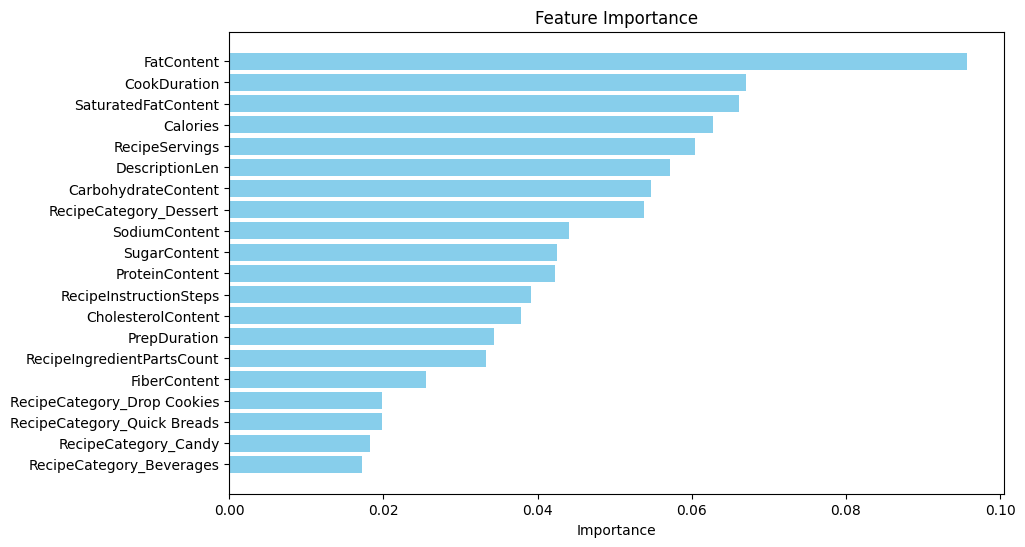

In [0]:
### Plot feature importance for top 20 variables
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances from the model
feature_importances = model.stages[-1].featureImportances
print(len(feature_importances))

importances = {feature_names[i]: importance for i, importance in enumerate(feature_importances)}

# Convert to pandas DataFrame for easier plotting
importances_df = pd.DataFrame(list(importances.items()), columns=['Feature', 'Importance'])
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df = importances_df.iloc[0:20, :]
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### multinomial logistic regression

In [0]:
assembler = VectorAssembler(
    inputCols=['DescriptionLen', 'RecipeInstructionSteps', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 
    'CookDuration', 'PrepDuration', 'RecipeIngredientPartsCount', 'RecipeCategoryVec'],
    outputCol='features')

lr = LogisticRegression(featuresCol = 'features', labelCol = 'AggregatedRatingBucket', maxIter=100)

pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(train)
lrModel = model.stages[-1]

predictions = model.transform(test)

In [0]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

Coefficients: 
DenseMatrix([[-4.23389539e-04, -2.67348029e-03, -6.39563620e-04,
               2.98836030e-03,  1.47696038e-03,  7.45393352e-05,
              -1.17224946e-06,  3.92940317e-03, -4.89110842e-03,
              -1.10929120e-03,  3.72294316e-03,  1.88720550e-04,
              -6.94636610e-06,  1.60408901e-05, -1.19491625e-02,
              -3.71072791e-01,  2.78797297e-03, -4.92991489e-01,
              -1.17319811e-01, -5.89195980e-01, -4.31711878e-01,
              -9.00347095e-01, -2.73113203e-01, -5.84503553e-01,
              -7.65189863e-02, -9.15909992e-01, -3.20666819e-01,
               1.03090206e-01, -1.88377030e-01, -4.70182405e-01,
              -4.00236344e-01,  1.01376280e-01,  2.03872812e-01,
              -1.87108762e-01, -3.58988200e-01, -2.93899382e-01,
              -1.55352736e-01, -5.49653483e-01,  2.64042495e-01,
              -6.50305383e-01, -3.77117379e-01, -5.52055860e-01,
              -8.24561515e-01, -5.34364220e-01, -8.97682396e-01,
          

In [0]:
# lrModel.coefficients
coefficients = lrModel.coefficients
features_and_coefficients = list(zip(feature_names, coefficients))
features_and_coefficients = [(x[0], float(x[1])) for x in features_and_coefficients]
df_coeffs = spark.createDataFrame(features_and_coefficients, ["Feature", "Coefficient"])
df_ordered = df_coeffs.orderBy(F.col("Coefficient").desc())
df_ordered.show(100, truncate=False)

+----------------------------------+----------------------+
|Feature                           |Coefficient           |
+----------------------------------+----------------------+
|RecipeCategory_Candy              |0.2640424951723782    |
|RecipeCategory_Drop Cookies       |0.2038728122213182    |
|RecipeCategory_Quick Breads       |0.10309020646172613   |
|RecipeCategory_Bar Cookie         |0.10137627995683403   |
|RecipeCategory_Cheesecake         |0.07329450230713179   |
|RecipeCategory_Asian              |0.047814255428360035  |
|CarbohydrateContent               |0.003929403166788123  |
|ProteinContent                    |0.0037229431605649566 |
|FatContent                        |0.002988360303642376  |
|RecipeCategory_Dessert            |0.002787972972858037  |
|SaturatedFatContent               |0.0014769603801006162 |
|RecipeServings                    |1.8872055048691332E-4 |
|CholesterolContent                |7.453933520317907E-5  |
|PrepDuration                      |1.60

In [0]:
len(coefficients)

73

In [0]:
# Getting the training summary
trainingSummary = lrModel.summary

In [0]:
# Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="AggregatedRatingBucket", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = %g" % accuracy)

Test Accuracy = 0.952436


In [0]:
# AUC
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='AggregatedRatingBucket')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9292529943458668


In [0]:
prob_udf = F.udf(lambda v: float(v[0]), FloatType())
predictions = predictions.withColumn('prob_positive', prob_udf(F.col('probability')))
threshold = predictions.approxQuantile("prob_positive", [1-0.04816], 0.01) # 0.04816 is the mean of y_train
threshold = threshold[0]
predictions = predictions.withColumn('prediction', F.when(F.col('prob_positive') > threshold, 1).otherwise(0))
predictions.groupBy('prediction').count().show()
predictions = predictions.withColumn('prediction', F.col('prediction').cast('double'))

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2643|
|         0|47437|
+----------+-----+



In [0]:
# Precision and recall
# Class-0
print('\n--------------Class-0----------------')
print('Precision          :', round(metrics.precision(0), 3))
print('recall             :', round(metrics.recall(0), 3))

# Class-1
print('\n--------------Class-1----------------')
print('Precision          :', round(metrics.precision(1), 3))
print('recall             :', round(metrics.recall(1), 3))

# F1 score
pre = metrics.precision(1)
rec = metrics.recall(1)
f1 = 1/(1/pre + 1/rec)
print('\n F1 score:', round(f1, 3))


--------------Class-0----------------
Precision          : 0.951
recall             : 0.946

--------------Class-1----------------
Precision          : 0.026
recall             : 0.029

 F1 score: 0.014


In [0]:
from sklearn.metrics import precision_recall_curve, auc

pdf = predictions.select("prediction", "AggregatedRatingBucket").toPandas()
precision, recall, _ = precision_recall_curve(pdf['AggregatedRatingBucket'], pdf['prediction'])
pr_auc = auc(recall, precision)
print(f"Area Under the Precision-Recall Curve: {pr_auc}")

Area Under the Precision-Recall Curve: 0.05101531650392221
